## Mounting Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Unzipping the data folder

In [ ]:
import zipfile
with zipfile.ZipFile("/content/drive/MyDrive/smai_a4/double_mnist.zip", 'r') as zip_ref:
    zip_ref.extractall("/content")

!rm -rf /content/__MACOSX

## Solving fragmentation issue for memory

In [ ]:
import os
os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'expandable_segments:True'

## Imports

In [ ]:
import torch
import torch.nn as nn
import numpy as np
import os
import sys
import cv2
import matplotlib.pyplot as plt
import time

## Function to plot graph

In [ ]:
def plot_loss_graph(train_loss_arr, val_loss_arr, save_as=None):
    # Plot the train loss and validation loss graph and save it to drive
    plt.figure(figsize=(10, 6))
    plt.plot(train_loss_arr, label='Training Loss', color='blue', marker='o')
    plt.plot(val_loss_arr, label='Validation Loss', color='orange', marker='o')

    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training vs Validation Loss')

    plt.legend()
    if save_as is None:
        plt.show()
    else:
        plt.savefig(save_as)

## DataLoader and CNN Class

In [ ]:
class MultiMNISTDataset:
    def __init__(self, data, labels, batch_size=32, shuffle=True, task="classification"):
        self.data = data
        self.labels = labels
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indexes = np.arange(len(self.data))  # Track the indexes for shuffling
        self.current_index = 0
        self.task = task

        if self.shuffle:
            self._shuffle_data()

    def _shuffle_data(self):
        np.random.shuffle(self.indexes)

    def __len__(self):
        return int(np.ceil(len(self.data) / self.batch_size))

    def __iter__(self):
        self.current_index = 0
        if self.shuffle:
            self._shuffle_data()
        return self

    def __next__(self):
        if self.current_index >= len(self.data):
            raise StopIteration

        # Compute the indices of the current batch
        start_idx = self.current_index
        end_idx = min(start_idx + self.batch_size, len(self.data))

        # Fetch the batch data and labels
        batch_indexes = self.indexes[start_idx:end_idx]
        batch_data = self.data[batch_indexes]
        batch_labels = self.labels[batch_indexes]

        # Update the current index
        self.current_index = end_idx

        # Convert NumPy arrays to PyTorch tensors
        batch_data_tensor = torch.from_numpy(batch_data).float()
        if self.task == "classification":
            batch_labels_tensor = torch.from_numpy(batch_labels).long()
        elif self.task == "regression":
            batch_labels_tensor = torch.from_numpy(batch_labels).float()

        return batch_data_tensor.unsqueeze(1), batch_labels_tensor

class CNN(nn.Module):
    def __init__(self, task: str, act_func: str, lr: float, dropout: float, optimiser: str):
        super(CNN, self).__init__()
        self.task = task # Can be regression/classification

        if task == 'classification':
            self.loss = nn.CrossEntropyLoss()
        elif task == 'regression':
            self.loss = nn.MSELoss()

        if act_func == 'relu':
            self.activation = torch.relu
        elif act_func == 'sigmoid':
            self.activation = torch.sigmoid
        elif act_func == 'tanh':
            self.activation = torch.tanh
        else:
            raise ValueError('Activation function not supported.')

        self.lr = lr
        self.dropout = dropout
        self.op = optimiser

        # Defining Layers, Input is 128x128x1 images
        self.conv1 = nn.Conv2d(1, 64, 5)
        self.maxpool1 = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(64, 128, 5)
        self.maxpool2 = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(128*29*29, 1024)
        self.fc2 = nn.Linear(1024, 10)
        if task == "regression":
            self.fc3 = nn.Linear(10, 1)

    def forward(self, x, return_intermediate_feature_maps=False):
        # x1 and x2 are intermediate feature maps for visualisation
        x1 = self.conv1(x)
        x1 = self.activation(x1)
        x1 = self.maxpool1(x1)

        x2 = self.conv2(x1)
        x2 = self.activation(x2)
        x2 = self.maxpool2(x2)

        x3 = x2.view(-1, 128*29*29)
        x3 = self.activation(self.fc1(x3))
        x3 = self.fc2(x3)
        if self.task == "regression":
            x3 = self.fc3(x3)

        if not return_intermediate_feature_maps:
            return x3
        else:
            return x1, x2, x3

    def visualise_feature_maps(self, x, y, save_as):
        self.eval()

        # Convert NumPy arrays to PyTorch tensors
        x = torch.from_numpy(x).float().unsqueeze(1)
        if self.task == "classification":
            y = torch.from_numpy(y).long()
        elif self.task == "regression":
            y = torch.from_numpy(y).float()

        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        x = x.to(device)
        x1, x2, _ = self.forward(x, return_intermediate_feature_maps=True)
        # x1 has 64 filters and x2 has 128 so only displaying first 64 filters of both the intermediate layers

        # Visualising layer 1 output
        for img_idx in range(x.shape[0]):
            fig, ax = plt.subplots(8, 8, figsize=(10, 10))
            for i in range(64):
                ax[i//8, i%8].imshow(x1[img_idx, i, :, :].detach().cpu().numpy(), cmap='viridis')
                ax[i//8, i%8].axis('off')
            plt.savefig(f"{save_as}_img_{img_idx}_label_{y[img_idx]}_x1.png")
            plt.close()

        # Visualising layer 2 output
        for img_idx in range(x.shape[0]):
            fig, ax = plt.subplots(8, 8, figsize=(10, 10))
            for i in range(64):
                ax[i//8, i%8].imshow(x2[img_idx, i, :, :].detach().cpu().numpy(), cmap='viridis')
                ax[i//8, i%8].axis('off')
            plt.savefig(f"{save_as}_img_{img_idx}_label_{y[img_idx]}_x2.png")
            plt.close()

    def train_model(self, x, y, val_x, val_y, epochs, batch_size=32):
        self.batch_size = batch_size
        torch.cuda.empty_cache()
        if self.op == 'adam':
            self.optimiser = torch.optim.Adam(self.parameters(), lr=self.lr)
        elif self.op == 'sgd':
            self.optimiser = torch.optim.SGD(self.parameters(), lr=self.lr)
        else:
            raise ValueError('Optimiser not supported.')

        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        train_dataloader = MultiMNISTDataset(x, y, batch_size=batch_size, task=self.task)
        val_dataloader = MultiMNISTDataset(val_x, val_y, batch_size=batch_size, task=self.task)

        train_loss_arr = list()
        val_loss_arr = list()

        train_iters = len(train_dataloader)
        val_iters = len(val_dataloader)

        for epoch in range(epochs):
            total_train_loss = 0
            total_val_loss = 0

            # Switching model to training mode
            self.train()

            for i, (images, labels) in enumerate(train_dataloader):
                train_images = images.to(device)
                train_labels = labels.to(device)

                # Forward Pass
                train_outputs = self.forward(train_images)
                train_loss = self.loss(train_outputs, train_labels)
                total_train_loss += train_loss.item()

                # Backward Pass
                self.optimiser.zero_grad()
                train_loss.backward()
                self.optimiser.step()
                print(f'Epoch {epoch+1}/{epochs}, iter [{i+1}/{train_iters}], Loss: {train_loss.item()}')
            avg_train_loss = total_train_loss / train_iters
            train_loss_arr.append(avg_train_loss)

            # Switching model to evaluation mode
            self.eval()

            # Calculating validation loss
            with torch.no_grad():
                for i, (val_images, val_labels) in enumerate(val_dataloader):
                    val_images = val_images.to(device)
                    val_labels = val_labels.to(device)
                    val_outputs = self.forward(val_images)
                    val_loss = self.loss(val_outputs, val_labels).item()
                    total_val_loss += val_loss
                avg_val_loss = total_val_loss / val_iters
                val_loss_arr.append(avg_val_loss)

        return train_loss_arr, val_loss_arr

    def accuracy(self, x, y):
        self.eval()
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        dataloader = MultiMNISTDataset(x, y, batch_size=self.batch_size, task=self.task)
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in dataloader:
                images = images.to(device)
                labels = labels.to(device)
                outputs = self.forward(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                # In case of regression I am rounding down the output value to integer as final predicted label
                if self.task == "regression":
                  predicted = torch.round(predicted.float())
                  labels = torch.round(labels)
                correct += (predicted == labels).sum().item()
        return correct / total

    def get_loss(self, x, y):
        self.eval()
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        dataloader = MultiMNISTDataset(x, y, batch_size=self.batch_size, task=self.task)
        iters = len(dataloader)
        with torch.no_grad():
            total_loss = 0
            for images, labels in dataloader:
                images = images.to(device)
                labels = labels.to(device)
                outputs = self.forward(images)
                total_loss += self.loss(outputs, labels).item()
        return total_loss / iters

## Function to Load data

In [ ]:
def load_mnist_data(base_dir_path):
    def load_data_for_folder(dir_path):
        images = []
        labels = []

        # Get all subdirectories
        dirs = [f for f in os.listdir(dir_path) if os.path.isdir(os.path.join(dir_path, f))]
        # Iterate over all subdirectories
        for sub_dir in dirs:
            label = len(sub_dir)
            sub_dir_path = dir_path + "/" + sub_dir
            # Get all image file names in the subdirectory
            img_files = [f for f in os.listdir(sub_dir_path) if os.path.isfile(os.path.join(sub_dir_path, f))]
            # Iterate over all images and read them
            for file in img_files:
                file_path = sub_dir_path + "/" + file
                img = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)
                images.append(img)
                labels.append(label)

        images = np.array(images)
        labels = np.array(labels)
        return images, labels

    # Loading train data
    train_data_dir = base_dir_path + "/train"
    train_images, train_labels = load_data_for_folder(train_data_dir)

    # Loading test data
    test_data_dir = base_dir_path + "/test"
    test_images, test_labels = load_data_for_folder(test_data_dir)

    # Loading val data
    val_data_dir = base_dir_path + "/val"
    val_images, val_labels = load_data_for_folder(val_data_dir)

    return train_images, train_labels, test_images, test_labels, val_images, val_labels

## Printing Data shape and statistics

In [ ]:
train_images, train_labels, test_images, test_labels, val_images, val_labels = load_mnist_data("/content/double_mnist")
print("Loaded MNIST data!")
print("Train data shape:", train_images.shape)
print("Test data shape:", test_images.shape)
print("Val data shape:", val_images.shape)
print("Number of train samples with 0 label:", np.sum(train_labels == 0))
print("Number of train samples with 1 label:", np.sum(train_labels == 1))
print("Number of train samples with 2 label:", np.sum(train_labels == 2))
print("Number of train samples with 3 label:", np.sum(train_labels == 3))
print("Train Label Shape:", train_labels.shape)

# Selecting images to be used for intermediate feature map visualisation
selected_images = list()
selected_labels = list()
labels_req = [1, 2, 3]
for image, label in zip(train_images, train_labels):
    if label in labels_req:
        selected_images.append(image)
        selected_labels.append(label)
        labels_req.remove(label)
        if len(labels_req) == 0:
            break
selected_images = np.array(selected_images)
selected_labels = np.array(selected_labels)

Loaded MNIST data!
Train data shape: (12600, 128, 128)
Test data shape: (4600, 128, 128)
Val data shape: (3000, 128, 128)
Number of train samples with 0 label: 0
Number of train samples with 1 label: 3000
Number of train samples with 2 label: 6400
Number of train samples with 3 label: 3200
Train Label Shape: (12600,)


## Selecting Device and Epochs

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
n_epochs = 20

print("Device:", device)

Device: cuda


## Defining Hyperparameters for 5 classification models

In [ ]:
model_hyperparams = [
    {
        "task": "classification",
        "act_func": "sigmoid",
        "lr": 0.001,
        "dropout": 0.5,
        "optimiser": "sgd",
        "model_name": "1"
    },
    {
        "task": "classification",
        "act_func": "relu",
        "lr": 0.001,
        "dropout": 0.8,
        "optimiser": "sgd",
        "model_name": "2"
    },
    {
        "task": "classification",
        "act_func": "relu",
        "lr": 0.001,
        "dropout": 0.5,
        "optimiser": "adam",
        "model_name": "3"
    },
    {
        "task": "classification",
        "act_func": "sigmoid",
        "lr": 0.01,
        "dropout": 0.5,
        "optimiser": "adam",
        "model_name": "4"
    },
    {
        "task": "classification",
        "act_func": "tanh",
        "lr": 0.001,
        "dropout": 0.5,
        "optimiser": "sgd",
        "model_name": "5"
    },
]

## Classification Model 1

Streaming output truncated to the last 5000 lines.
Epoch 8/20, iter [139/394], Loss: 0.9688066840171814
Epoch 8/20, iter [140/394], Loss: 1.0300571918487549
Epoch 8/20, iter [141/394], Loss: 0.8365904092788696
Epoch 8/20, iter [142/394], Loss: 0.9275428652763367
Epoch 8/20, iter [143/394], Loss: 1.14998197555542
Epoch 8/20, iter [144/394], Loss: 1.1700891256332397
Epoch 8/20, iter [145/394], Loss: 1.045479416847229
Epoch 8/20, iter [146/394], Loss: 1.0659162998199463
Epoch 8/20, iter [147/394], Loss: 1.0347241163253784
Epoch 8/20, iter [148/394], Loss: 1.0825812816619873
Epoch 8/20, iter [149/394], Loss: 0.9781726002693176
Epoch 8/20, iter [150/394], Loss: 0.930418074131012
Epoch 8/20, iter [151/394], Loss: 1.0114840269088745
Epoch 8/20, iter [152/394], Loss: 1.0059243440628052
Epoch 8/20, iter [153/394], Loss: 1.0599902868270874
Epoch 8/20, iter [154/394], Loss: 0.8888438940048218
Epoch 8/20, iter [155/394], Loss: 0.9220849871635437
Epoch 8/20, iter [156/394], Loss: 1.1116317510604858

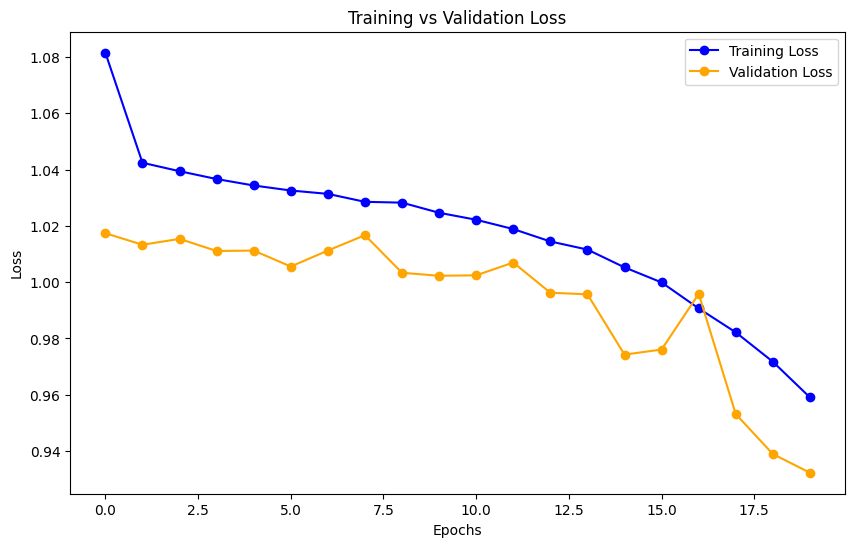

In [ ]:
# Extracting model 1 hyper-parameters
model_num = 1
hyperparams = model_hyperparams[model_num - 1]

# Training the model
model = CNN(task=hyperparams["task"], act_func=hyperparams["act_func"], lr=hyperparams["lr"], dropout=hyperparams["dropout"], optimiser=hyperparams["optimiser"]).to(device)
print(f"Training started of Model {hyperparams['model_name']}, with parameters:\n{hyperparams}")
start_time = time.time()
train_loss_arr, val_loss_arr = model.train_model(train_images, train_labels, val_images, val_labels, n_epochs)
end_time = time.time()
print("\nTraining Complete, time taken:", end_time - start_time)
print(f"Accuracy: {round(model.accuracy(test_images, test_labels) * 100, 3)}%")

# Plotting loss graph
plot_loss_graph(train_loss_arr, val_loss_arr, f"/content/drive/MyDrive/smai_a4/figures/{hyperparams['task']}/model_{hyperparams['model_name']}_loss.png")

# Saving the model
torch.save(model.state_dict(), f"/content/drive/MyDrive/smai_a4/saved_models/{hyperparams['task']}/model_{hyperparams["model_name"]}.pth")
print(f"Saved {hyperparams['task']} model {hyperparams['model_name']}")

## Classification Model 2

Streaming output truncated to the last 5000 lines.
Epoch 8/20, iter [139/394], Loss: 0.00022618967341259122
Epoch 8/20, iter [140/394], Loss: 0.0026783121284097433
Epoch 8/20, iter [141/394], Loss: 0.005288273561745882
Epoch 8/20, iter [142/394], Loss: 0.005466198083013296
Epoch 8/20, iter [143/394], Loss: 0.0026785789523273706
Epoch 8/20, iter [144/394], Loss: 0.005354199558496475
Epoch 8/20, iter [145/394], Loss: 0.00022879702737554908
Epoch 8/20, iter [146/394], Loss: 0.0001344072661595419
Epoch 8/20, iter [147/394], Loss: 0.0002999503049068153
Epoch 8/20, iter [148/394], Loss: 0.005698543973267078
Epoch 8/20, iter [149/394], Loss: 0.0027048641350120306
Epoch 8/20, iter [150/394], Loss: 0.0026622293516993523
Epoch 8/20, iter [151/394], Loss: 0.0028449338860809803
Epoch 8/20, iter [152/394], Loss: 0.0026663399767130613
Epoch 8/20, iter [153/394], Loss: 0.0029056945350021124
Epoch 8/20, iter [154/394], Loss: 0.00787442922592163
Epoch 8/20, iter [155/394], Loss: 0.005352668464183807
Ep

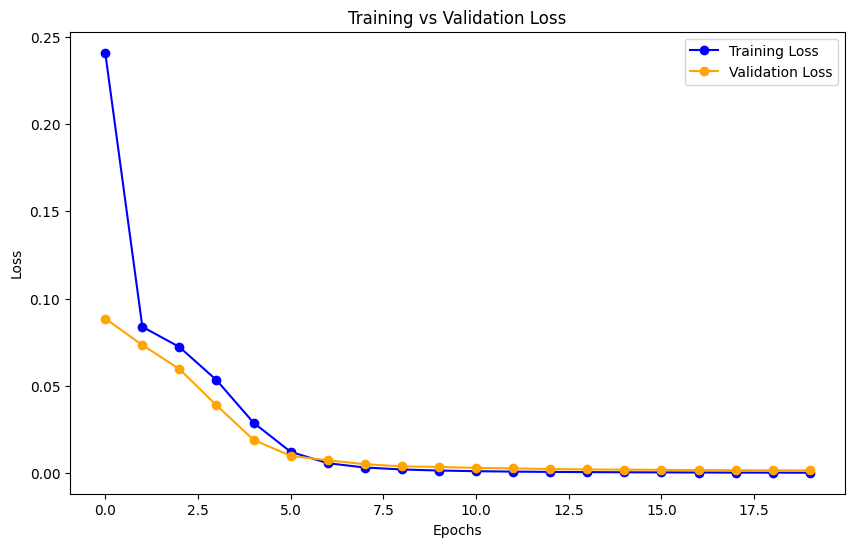

In [ ]:
# Extracting model 2 hyper-parameters
model_num = 2
hyperparams = model_hyperparams[model_num - 1]

# Training the model
model = CNN(task=hyperparams["task"], act_func=hyperparams["act_func"], lr=hyperparams["lr"], dropout=hyperparams["dropout"], optimiser=hyperparams["optimiser"]).to(device)
print(f"Training started of Model {hyperparams['model_name']}, with parameters:\n{hyperparams}")
start_time = time.time()
train_loss_arr, val_loss_arr = model.train_model(train_images, train_labels, val_images, val_labels, n_epochs)
end_time = time.time()
print("\nTraining Complete, time taken:", end_time - start_time)
print(f"Accuracy: {round(model.accuracy(test_images, test_labels) * 100, 3)}%")

# Plotting loss graph
plot_loss_graph(train_loss_arr, val_loss_arr, f"/content/drive/MyDrive/smai_a4/figures/{hyperparams['task']}/model_{hyperparams['model_name']}_loss.png")

# Saving the model
torch.save(model.state_dict(), f"/content/drive/MyDrive/smai_a4/saved_models/{hyperparams['task']}/model_{hyperparams['model_name']}.pth")
print(f"Saved {hyperparams['task']} model {hyperparams['model_name']}")

## Classification Model 3

Streaming output truncated to the last 5000 lines.
Epoch 8/20, iter [139/394], Loss: 0.0
Epoch 8/20, iter [140/394], Loss: 0.00042190414387732744
Epoch 8/20, iter [141/394], Loss: 4.03114318032749e-05
Epoch 8/20, iter [142/394], Loss: 4.03114318032749e-05
Epoch 8/20, iter [143/394], Loss: 8.06228636065498e-05
Epoch 8/20, iter [144/394], Loss: 8.06079842732288e-05
Epoch 8/20, iter [145/394], Loss: 4.029654883197509e-05
Epoch 8/20, iter [146/394], Loss: 0.0001543062535347417
Epoch 8/20, iter [147/394], Loss: 0.0
Epoch 8/20, iter [148/394], Loss: 8.054101635934785e-05
Epoch 8/20, iter [149/394], Loss: 4.025562520837411e-05
Epoch 8/20, iter [150/394], Loss: 4.0244463889393955e-05
Epoch 8/20, iter [151/394], Loss: 4.022958091809414e-05
Epoch 8/20, iter [152/394], Loss: 8.043683919822797e-05
Epoch 8/20, iter [153/394], Loss: 0.0
Epoch 8/20, iter [154/394], Loss: 4.018865729449317e-05
Epoch 8/20, iter [155/394], Loss: 0.00012054364196956158
Epoch 8/20, iter [156/394], Loss: 0.0
Epoch 8/20, it

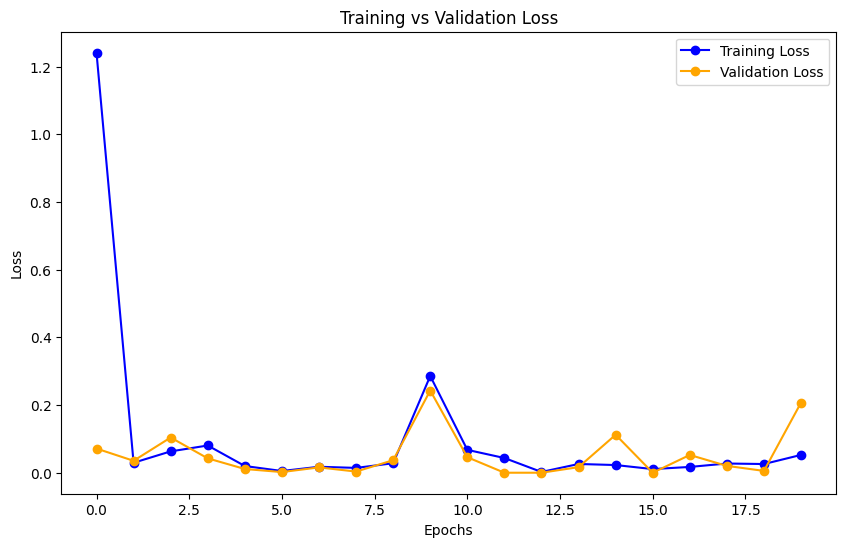

In [ ]:
# Extracting model 3 hyper-parameters
model_num = 3
hyperparams = model_hyperparams[model_num - 1]

# Training the model
model = CNN(task=hyperparams["task"], act_func=hyperparams["act_func"], lr=hyperparams["lr"], dropout=hyperparams["dropout"], optimiser=hyperparams["optimiser"]).to(device)
print(f"Training started of Model {hyperparams['model_name']}, with parameters:\n{hyperparams}")
start_time = time.time()
train_loss_arr, val_loss_arr = model.train_model(train_images, train_labels, val_images, val_labels, n_epochs)
end_time = time.time()
print("\nTraining Complete, time taken:", end_time - start_time)
print(f"Accuracy: {round(model.accuracy(test_images, test_labels) * 100, 3)}%")

# Plotting loss graph
plot_loss_graph(train_loss_arr, val_loss_arr, f"/content/drive/MyDrive/smai_a4/figures/{hyperparams['task']}/model_{hyperparams['model_name']}_loss.png")

# Saving the model
torch.save(model.state_dict(), f"/content/drive/MyDrive/smai_a4/saved_models/{hyperparams['task']}/model_{hyperparams['model_name']}.pth")
print(f"Saved {hyperparams['task']} model {hyperparams['model_name']}")

## Classification Model 4

Streaming output truncated to the last 5000 lines.
Epoch 8/20, iter [127/394], Loss: 1.2320826053619385
Epoch 8/20, iter [128/394], Loss: 1.2007015943527222
Epoch 8/20, iter [129/394], Loss: 0.9900769591331482
Epoch 8/20, iter [130/394], Loss: 1.343163013458252
Epoch 8/20, iter [131/394], Loss: 1.6864339113235474
Epoch 8/20, iter [132/394], Loss: 1.1375799179077148
Epoch 8/20, iter [133/394], Loss: 1.6711169481277466
Epoch 8/20, iter [134/394], Loss: 2.116537094116211
Epoch 8/20, iter [135/394], Loss: 1.3062434196472168
Epoch 8/20, iter [136/394], Loss: 1.3872756958007812
Epoch 8/20, iter [137/394], Loss: 1.358754277229309
Epoch 8/20, iter [138/394], Loss: 1.5311685800552368
Epoch 8/20, iter [139/394], Loss: 1.1184002161026
Epoch 8/20, iter [140/394], Loss: 1.3124593496322632
Epoch 8/20, iter [141/394], Loss: 1.42412269115448
Epoch 8/20, iter [142/394], Loss: 1.4277437925338745
Epoch 8/20, iter [143/394], Loss: 1.0309664011001587
Epoch 8/20, iter [144/394], Loss: 1.9313231706619263
Epo

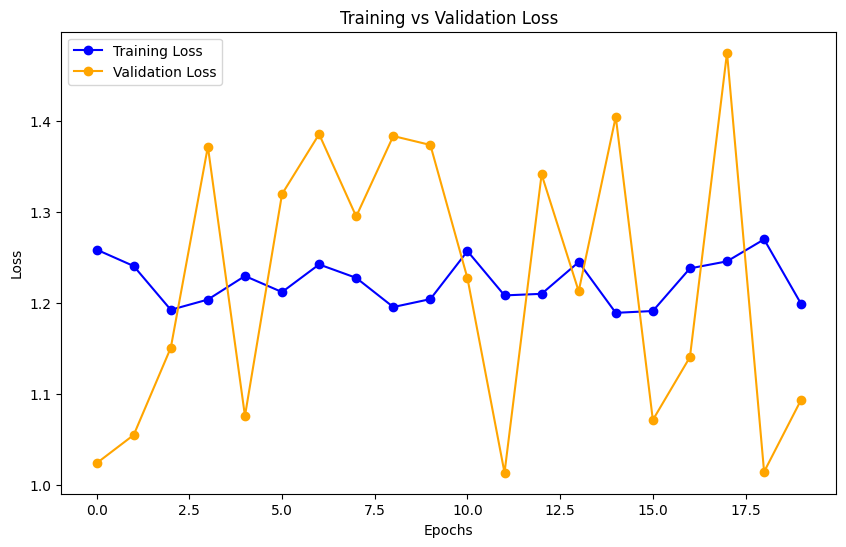

In [ ]:
# Extracting model 4 hyper-parameters
model_num = 4
hyperparams = model_hyperparams[model_num - 1]

# Training the model
model = CNN(task=hyperparams["task"], act_func=hyperparams["act_func"], lr=hyperparams["lr"], dropout=hyperparams["dropout"], optimiser=hyperparams["optimiser"]).to(device)
print(f"Training started of Model {hyperparams['model_name']}, with parameters:\n{hyperparams}")
start_time = time.time()
train_loss_arr, val_loss_arr = model.train_model(train_images, train_labels, val_images, val_labels, n_epochs)
end_time = time.time()
print("\nTraining Complete, time taken:", end_time - start_time)
print(f"Accuracy: {round(model.accuracy(test_images, test_labels) * 100, 3)}%")

# Plotting loss graph
plot_loss_graph(train_loss_arr, val_loss_arr, f"/content/drive/MyDrive/smai_a4/figures/{hyperparams['task']}/model_{hyperparams['model_name']}_loss.png")

# Saving the model
torch.save(model.state_dict(), f"/content/drive/MyDrive/smai_a4/saved_models/{hyperparams['task']}/model_{hyperparams['model_name']}.pth")
print(f"Saved {hyperparams['task']} model {hyperparams['model_name']}")

## Classification Model 5

Streaming output truncated to the last 5000 lines.
Epoch 8/20, iter [127/394], Loss: 0.010876534506678581
Epoch 8/20, iter [128/394], Loss: 0.023876933380961418
Epoch 8/20, iter [129/394], Loss: 0.0168252345174551
Epoch 8/20, iter [130/394], Loss: 0.02632163278758526
Epoch 8/20, iter [131/394], Loss: 0.008583788760006428
Epoch 8/20, iter [132/394], Loss: 0.045702751725912094
Epoch 8/20, iter [133/394], Loss: 0.013621613383293152
Epoch 8/20, iter [134/394], Loss: 0.017040155827999115
Epoch 8/20, iter [135/394], Loss: 0.014611029997467995
Epoch 8/20, iter [136/394], Loss: 0.013235819526016712
Epoch 8/20, iter [137/394], Loss: 0.008070475421845913
Epoch 8/20, iter [138/394], Loss: 0.023745499551296234
Epoch 8/20, iter [139/394], Loss: 0.023669134825468063
Epoch 8/20, iter [140/394], Loss: 0.049262139946222305
Epoch 8/20, iter [141/394], Loss: 0.021865034475922585
Epoch 8/20, iter [142/394], Loss: 0.011522172018885612
Epoch 8/20, iter [143/394], Loss: 0.014148046262562275
Epoch 8/20, iter 

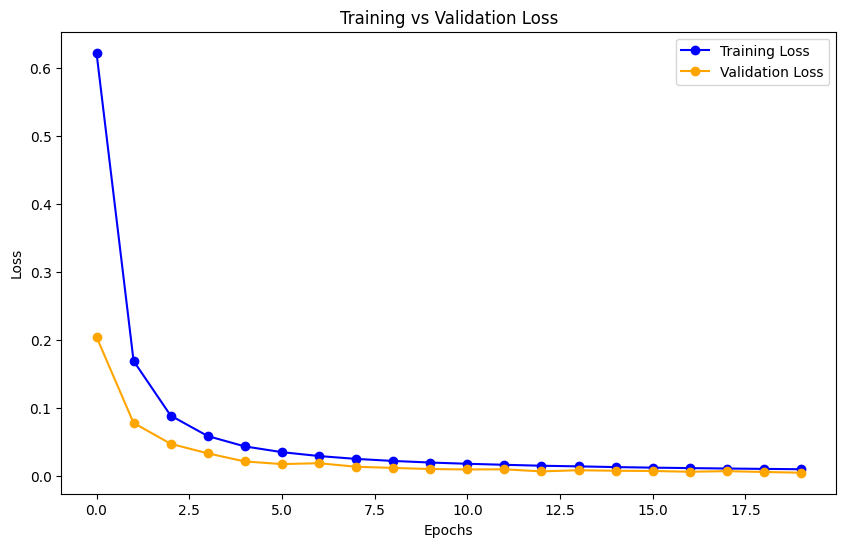

In [ ]:
# Extracting model 5 hyper-parameters
model_num = 5
hyperparams = model_hyperparams[model_num - 1]

# Training the model
model = CNN(task=hyperparams["task"], act_func=hyperparams["act_func"], lr=hyperparams["lr"], dropout=hyperparams["dropout"], optimiser=hyperparams["optimiser"]).to(device)
print(f"Training started of Model {hyperparams['model_name']}, with parameters:\n{hyperparams}")
start_time = time.time()
train_loss_arr, val_loss_arr = model.train_model(train_images, train_labels, val_images, val_labels, n_epochs)
end_time = time.time()
print("\nTraining Complete, time taken:", end_time - start_time)
print(f"Accuracy: {round(model.accuracy(test_images, test_labels) * 100, 3)}%")

# Plotting loss graph
plot_loss_graph(train_loss_arr, val_loss_arr, f"/content/drive/MyDrive/smai_a4/figures/{hyperparams['task']}/model_{hyperparams['model_name']}_loss.png")

# Saving the model
torch.save(model.state_dict(), f"/content/drive/MyDrive/smai_a4/saved_models/{hyperparams['task']}/model_{hyperparams['model_name']}.pth")
print(f"Saved {hyperparams['task']} model {hyperparams['model_name']}")

## Defining Hyperparameters for 5 regression models

In [ ]:
regression_model_hyperparams = [
    {
        "task": "regression",
        "act_func": "sigmoid",
        "lr": 0.001,
        "dropout": 0.5,
        "optimiser": "sgd",
        "model_name": "1"
    },
    {
        "task": "regression",
        "act_func": "relu",
        "lr": 0.001,
        "dropout": 0.8,
        "optimiser": "sgd",
        "model_name": "2"
    },
    {
        "task": "regression",
        "act_func": "relu",
        "lr": 0.001,
        "dropout": 0.5,
        "optimiser": "adam",
        "model_name": "3"
    },
    {
        "task": "regression",
        "act_func": "sigmoid",
        "lr": 0.01,
        "dropout": 0.5,
        "optimiser": "adam",
        "model_name": "4"
    },
    {
        "task": "regression",
        "act_func": "tanh",
        "lr": 0.001,
        "dropout": 0.5,
        "optimiser": "sgd",
        "model_name": "5"
    },
]

## Regression Model 1

Training started of Model 1, with parameters:
{'task': 'regression', 'act_func': 'sigmoid', 'lr': 0.001, 'dropout': 0.5, 'optimiser': 'sgd', 'model_name': '1'}


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 1/20, iter [1/394], Loss: 3.824826717376709
Epoch 1/20, iter [2/394], Loss: 0.6642477512359619
Epoch 1/20, iter [3/394], Loss: 0.6690719127655029
Epoch 1/20, iter [4/394], Loss: 0.5938478708267212
Epoch 1/20, iter [5/394], Loss: 0.5048010349273682
Epoch 1/20, iter [6/394], Loss: 0.5842352509498596
Epoch 1/20, iter [7/394], Loss: 0.6394085884094238
Epoch 1/20, iter [8/394], Loss: 0.565666913986206
Epoch 1/20, iter [9/394], Loss: 0.4133634865283966
Epoch 1/20, iter [10/394], Loss: 0.6795778274536133
Epoch 1/20, iter [11/394], Loss: 0.4706480801105499
Epoch 1/20, iter [12/394], Loss: 0.5295182466506958
Epoch 1/20, iter [13/394], Loss: 0.4961046576499939
Epoch 1/20, iter [14/394], Loss: 0.4531949758529663
Epoch 1/20, iter [15/394], Loss: 0.5469226241111755
Epoch 1/20, iter [16/394], Loss: 0.6161917448043823
Epoch 1/20, iter [17/394], Loss: 0.4489275813102722
Epoch 1/20, iter [18/394], Loss: 0.4853019714355469
Epoch 1/20, iter [19/394], Loss: 0.4405018091201782
Epoch 1/20, iter [20/39

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([24])) that is different to the input size (torch.Size([24, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Streaming output truncated to the last 5000 lines.
Epoch 8/20, iter [127/394], Loss: 0.3492034673690796
Epoch 8/20, iter [128/394], Loss: 0.4749869704246521
Epoch 8/20, iter [129/394], Loss: 0.4145859479904175
Epoch 8/20, iter [130/394], Loss: 0.5712904930114746
Epoch 8/20, iter [131/394], Loss: 0.4161863327026367
Epoch 8/20, iter [132/394], Loss: 0.5915546417236328
Epoch 8/20, iter [133/394], Loss: 0.40549665689468384
Epoch 8/20, iter [134/394], Loss: 0.549891471862793
Epoch 8/20, iter [135/394], Loss: 0.5043204426765442
Epoch 8/20, iter [136/394], Loss: 0.46291548013687134
Epoch 8/20, iter [137/394], Loss: 0.4336056709289551
Epoch 8/20, iter [138/394], Loss: 0.5234756469726562
Epoch 8/20, iter [139/394], Loss: 0.5773397088050842
Epoch 8/20, iter [140/394], Loss: 0.6297990083694458
Epoch 8/20, iter [141/394], Loss: 0.4678643047809601
Epoch 8/20, iter [142/394], Loss: 0.5013177990913391
Epoch 8/20, iter [143/394], Loss: 0.6553747057914734
Epoch 8/20, iter [144/394], Loss: 0.53957277536

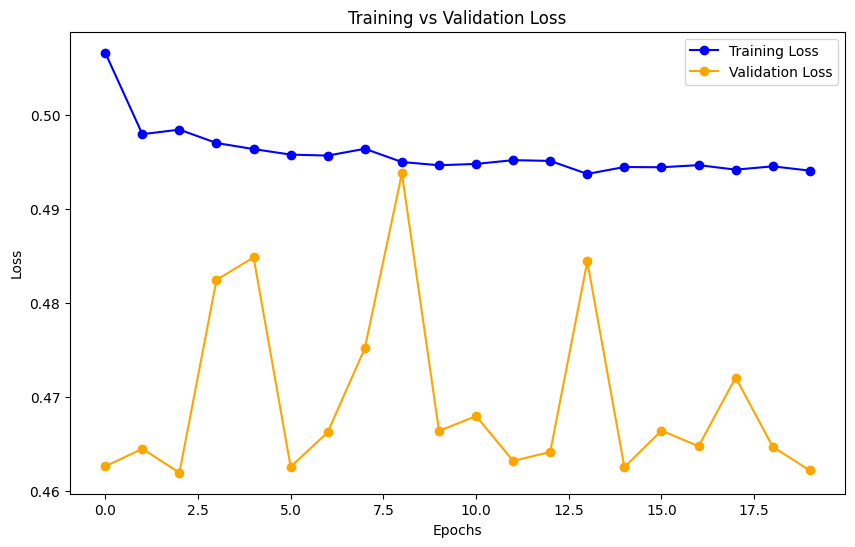

In [ ]:
# Extracting model 1 hyper-parameters
model_num = 1
hyperparams = regression_model_hyperparams[model_num - 1]

# Training the model
model = CNN(task=hyperparams["task"], act_func=hyperparams["act_func"], lr=hyperparams["lr"], dropout=hyperparams["dropout"], optimiser=hyperparams["optimiser"]).to(device)
print(f"Training started of Model {hyperparams['model_name']}, with parameters:\n{hyperparams}")
start_time = time.time()
train_loss_arr, val_loss_arr = model.train_model(train_images, train_labels, val_images, val_labels, n_epochs)
end_time = time.time()
print("\nTraining Complete, time taken:", end_time - start_time)
print(f"Test Accuracy: {model.accuracy(test_images, test_labels)}")
print(f"Test MSE: {model.get_loss(test_images, test_labels)}")

# Plotting loss graph
plot_loss_graph(train_loss_arr, val_loss_arr, f"/content/drive/MyDrive/smai_a4/figures/{hyperparams['task']}/model_{hyperparams['model_name']}_loss.png")

# Saving the model
torch.save(model.state_dict(), f"/content/drive/MyDrive/smai_a4/saved_models/{hyperparams['task']}/model_{hyperparams['model_name']}.pth")
print(f"Saved {hyperparams['task']} model {hyperparams['model_name']}")

## Regression Model 2

Training started of Model 2, with parameters:
{'task': 'regression', 'act_func': 'relu', 'lr': 0.001, 'dropout': 0.8, 'optimiser': 'sgd', 'model_name': '2'}
Epoch 1/20, iter [1/394], Loss: 8.73296070098877


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 1/20, iter [2/394], Loss: 15774.923828125
Epoch 1/20, iter [3/394], Loss: 2324311.5
Epoch 1/20, iter [4/394], Loss: 8.384586261752339e+31
Epoch 1/20, iter [5/394], Loss: nan
Epoch 1/20, iter [6/394], Loss: nan
Epoch 1/20, iter [7/394], Loss: nan
Epoch 1/20, iter [8/394], Loss: nan
Epoch 1/20, iter [9/394], Loss: nan
Epoch 1/20, iter [10/394], Loss: nan
Epoch 1/20, iter [11/394], Loss: nan
Epoch 1/20, iter [12/394], Loss: nan
Epoch 1/20, iter [13/394], Loss: nan
Epoch 1/20, iter [14/394], Loss: nan
Epoch 1/20, iter [15/394], Loss: nan
Epoch 1/20, iter [16/394], Loss: nan
Epoch 1/20, iter [17/394], Loss: nan
Epoch 1/20, iter [18/394], Loss: nan
Epoch 1/20, iter [19/394], Loss: nan
Epoch 1/20, iter [20/394], Loss: nan
Epoch 1/20, iter [21/394], Loss: nan
Epoch 1/20, iter [22/394], Loss: nan
Epoch 1/20, iter [23/394], Loss: nan
Epoch 1/20, iter [24/394], Loss: nan
Epoch 1/20, iter [25/394], Loss: nan
Epoch 1/20, iter [26/394], Loss: nan
Epoch 1/20, iter [27/394], Loss: nan
Epoch 1/20

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([24])) that is different to the input size (torch.Size([24, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Streaming output truncated to the last 5000 lines.
Epoch 8/20, iter [128/394], Loss: nan
Epoch 8/20, iter [129/394], Loss: nan
Epoch 8/20, iter [130/394], Loss: nan
Epoch 8/20, iter [131/394], Loss: nan
Epoch 8/20, iter [132/394], Loss: nan
Epoch 8/20, iter [133/394], Loss: nan
Epoch 8/20, iter [134/394], Loss: nan
Epoch 8/20, iter [135/394], Loss: nan
Epoch 8/20, iter [136/394], Loss: nan
Epoch 8/20, iter [137/394], Loss: nan
Epoch 8/20, iter [138/394], Loss: nan
Epoch 8/20, iter [139/394], Loss: nan
Epoch 8/20, iter [140/394], Loss: nan
Epoch 8/20, iter [141/394], Loss: nan
Epoch 8/20, iter [142/394], Loss: nan
Epoch 8/20, iter [143/394], Loss: nan
Epoch 8/20, iter [144/394], Loss: nan
Epoch 8/20, iter [145/394], Loss: nan
Epoch 8/20, iter [146/394], Loss: nan
Epoch 8/20, iter [147/394], Loss: nan
Epoch 8/20, iter [148/394], Loss: nan
Epoch 8/20, iter [149/394], Loss: nan
Epoch 8/20, iter [150/394], Loss: nan
Epoch 8/20, iter [151/394], Loss: nan
Epoch 8/20, iter [152/394], Loss: nan

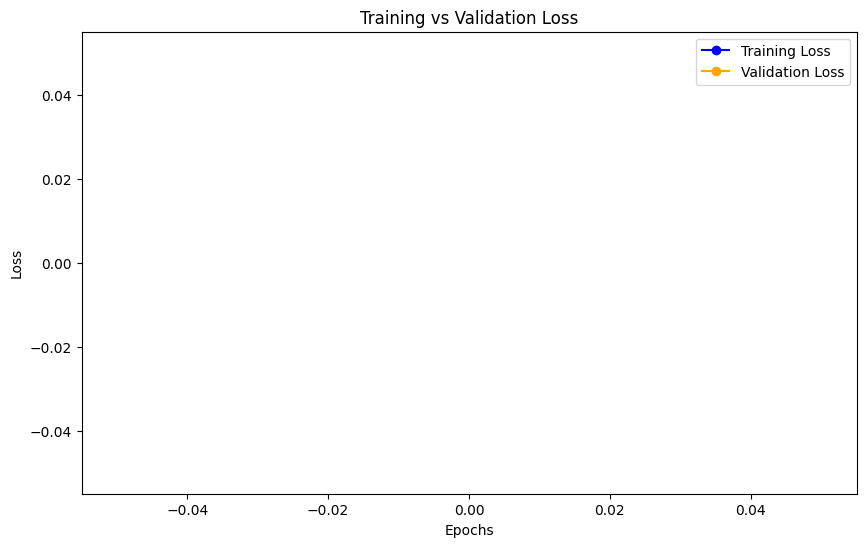

In [ ]:
# Extracting model 2 hyper-parameters
model_num = 2
hyperparams = regression_model_hyperparams[model_num - 1]

# Training the model
model = CNN(task=hyperparams["task"], act_func=hyperparams["act_func"], lr=hyperparams["lr"], dropout=hyperparams["dropout"], optimiser=hyperparams["optimiser"]).to(device)
print(f"Training started of Model {hyperparams['model_name']}, with parameters:\n{hyperparams}")
start_time = time.time()
train_loss_arr, val_loss_arr = model.train_model(train_images, train_labels, val_images, val_labels, n_epochs)
end_time = time.time()
print("\nTraining Complete, time taken:", end_time - start_time)
print(f"Test Accuracy: {model.accuracy(test_images, test_labels)}")
print(f"Test MSE: {model.get_loss(test_images, test_labels)}")

# Plotting loss graph
plot_loss_graph(train_loss_arr, val_loss_arr, f"/content/drive/MyDrive/smai_a4/figures/{hyperparams['task']}/model_{hyperparams['model_name']}_loss.png")

# Saving the model
torch.save(model.state_dict(), f"/content/drive/MyDrive/smai_a4/saved_models/{hyperparams['task']}/model_{hyperparams['model_name']}.pth")
print(f"Saved {hyperparams['task']} model {hyperparams['model_name']}")

## Regression Model 3

Streaming output truncated to the last 5000 lines.
Epoch 8/20, iter [128/394], Loss: 0.4812070429325104
Epoch 8/20, iter [129/394], Loss: 0.6033359169960022
Epoch 8/20, iter [130/394], Loss: 0.5625695586204529
Epoch 8/20, iter [131/394], Loss: 0.4735649824142456
Epoch 8/20, iter [132/394], Loss: 0.4927104711532593
Epoch 8/20, iter [133/394], Loss: 0.5707972049713135
Epoch 8/20, iter [134/394], Loss: 0.5432982444763184
Epoch 8/20, iter [135/394], Loss: 0.504435658454895
Epoch 8/20, iter [136/394], Loss: 0.5727529525756836
Epoch 8/20, iter [137/394], Loss: 0.6385818719863892
Epoch 8/20, iter [138/394], Loss: 0.6593211889266968
Epoch 8/20, iter [139/394], Loss: 0.41230931878089905
Epoch 8/20, iter [140/394], Loss: 0.5325484871864319
Epoch 8/20, iter [141/394], Loss: 0.4038550853729248
Epoch 8/20, iter [142/394], Loss: 0.4212464392185211
Epoch 8/20, iter [143/394], Loss: 0.42990145087242126
Epoch 8/20, iter [144/394], Loss: 0.39133578538894653
Epoch 8/20, iter [145/394], Loss: 0.4104152321

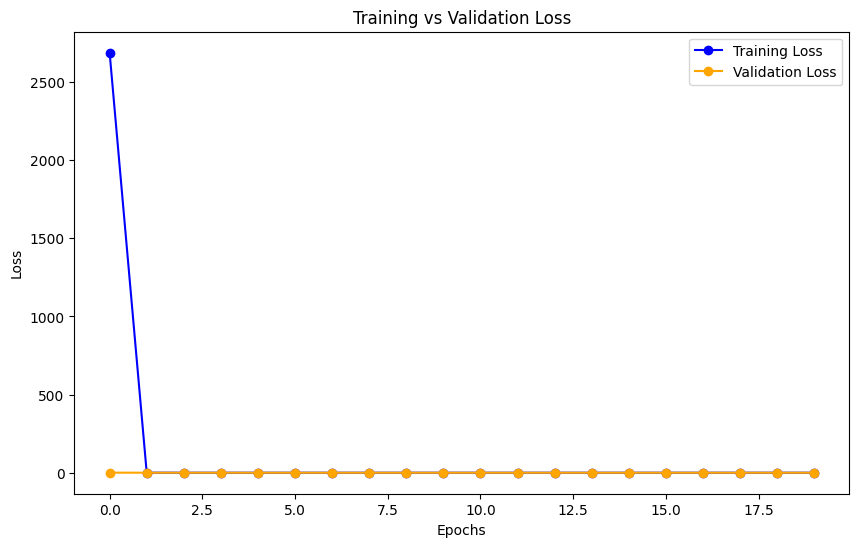

In [ ]:
# Extracting model 3 hyper-parameters
model_num = 3
hyperparams = regression_model_hyperparams[model_num - 1]

# Training the model
model = CNN(task=hyperparams["task"], act_func=hyperparams["act_func"], lr=hyperparams["lr"], dropout=hyperparams["dropout"], optimiser=hyperparams["optimiser"]).to(device)
print(f"Training started of Model {hyperparams['model_name']}, with parameters:\n{hyperparams}")
start_time = time.time()
train_loss_arr, val_loss_arr = model.train_model(train_images, train_labels, val_images, val_labels, n_epochs)
end_time = time.time()
print("\nTraining Complete, time taken:", end_time - start_time)
print(f"Test Accuracy: {model.accuracy(test_images, test_labels)}")
print(f"Test MSE: {model.get_loss(test_images, test_labels)}")

# Plotting loss graph
plot_loss_graph(train_loss_arr, val_loss_arr, f"/content/drive/MyDrive/smai_a4/figures/{hyperparams['task']}/model_{hyperparams['model_name']}_loss.png")

# Saving the model
torch.save(model.state_dict(), f"/content/drive/MyDrive/smai_a4/saved_models/{hyperparams['task']}/model_{hyperparams['model_name']}.pth")
print(f"Saved {hyperparams['task']} model {hyperparams['model_name']}")

## Regression Model 4

Streaming output truncated to the last 5000 lines.
Epoch 8/20, iter [128/394], Loss: 0.4644355773925781
Epoch 8/20, iter [129/394], Loss: 0.44912225008010864
Epoch 8/20, iter [130/394], Loss: 0.4285556674003601
Epoch 8/20, iter [131/394], Loss: 0.5526871681213379
Epoch 8/20, iter [132/394], Loss: 0.5117805004119873
Epoch 8/20, iter [133/394], Loss: 0.45434457063674927
Epoch 8/20, iter [134/394], Loss: 0.4654516279697418
Epoch 8/20, iter [135/394], Loss: 0.5318077206611633
Epoch 8/20, iter [136/394], Loss: 0.7428619861602783
Epoch 8/20, iter [137/394], Loss: 0.5667589902877808
Epoch 8/20, iter [138/394], Loss: 0.5582571029663086
Epoch 8/20, iter [139/394], Loss: 0.37879061698913574
Epoch 8/20, iter [140/394], Loss: 0.33612021803855896
Epoch 8/20, iter [141/394], Loss: 0.5909521579742432
Epoch 8/20, iter [142/394], Loss: 0.6127400994300842
Epoch 8/20, iter [143/394], Loss: 0.5361562967300415
Epoch 8/20, iter [144/394], Loss: 0.7116886377334595
Epoch 8/20, iter [145/394], Loss: 0.43203753

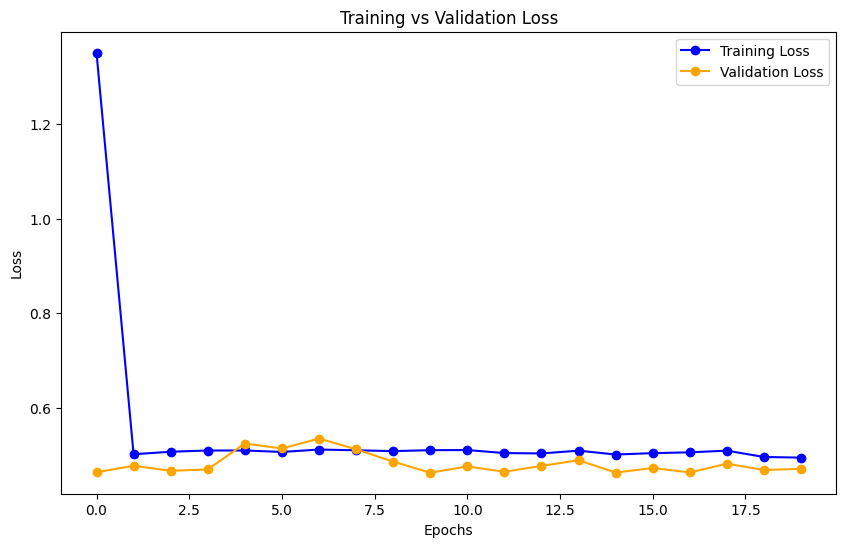

In [ ]:
# Extracting model 4 hyper-parameters
model_num = 4
hyperparams = regression_model_hyperparams[model_num - 1]

# Training the model
model = CNN(task=hyperparams["task"], act_func=hyperparams["act_func"], lr=hyperparams["lr"], dropout=hyperparams["dropout"], optimiser=hyperparams["optimiser"]).to(device)
print(f"Training started of Model {hyperparams['model_name']}, with parameters:\n{hyperparams}")
start_time = time.time()
train_loss_arr, val_loss_arr = model.train_model(train_images, train_labels, val_images, val_labels, n_epochs)
end_time = time.time()
print("\nTraining Complete, time taken:", end_time - start_time)
print(f"Test Accuracy: {model.accuracy(test_images, test_labels)}")
print(f"Test MSE: {model.get_loss(test_images, test_labels)}")

# Plotting loss graph
plot_loss_graph(train_loss_arr, val_loss_arr, f"/content/drive/MyDrive/smai_a4/figures/{hyperparams['task']}/model_{hyperparams['model_name']}_loss.png")

# Saving the model
torch.save(model.state_dict(), f"/content/drive/MyDrive/smai_a4/saved_models/{hyperparams['task']}/model_{hyperparams['model_name']}.pth")
print(f"Saved {hyperparams['task']} model {hyperparams['model_name']}")

## Regression Model 5

Streaming output truncated to the last 5000 lines.
Epoch 8/20, iter [128/394], Loss: 0.501051664352417
Epoch 8/20, iter [129/394], Loss: 0.5632182359695435
Epoch 8/20, iter [130/394], Loss: 0.46414560079574585
Epoch 8/20, iter [131/394], Loss: 0.5101048350334167
Epoch 8/20, iter [132/394], Loss: 0.4661376476287842
Epoch 8/20, iter [133/394], Loss: 0.5309780836105347
Epoch 8/20, iter [134/394], Loss: 0.47727930545806885
Epoch 8/20, iter [135/394], Loss: 0.6253710985183716
Epoch 8/20, iter [136/394], Loss: 0.4087586998939514
Epoch 8/20, iter [137/394], Loss: 0.5644130706787109
Epoch 8/20, iter [138/394], Loss: 0.58411705493927
Epoch 8/20, iter [139/394], Loss: 0.4904930889606476
Epoch 8/20, iter [140/394], Loss: 0.5383278727531433
Epoch 8/20, iter [141/394], Loss: 0.6640405058860779
Epoch 8/20, iter [142/394], Loss: 0.5973465442657471
Epoch 8/20, iter [143/394], Loss: 0.5668810606002808
Epoch 8/20, iter [144/394], Loss: 0.43858224153518677
Epoch 8/20, iter [145/394], Loss: 0.479644894599

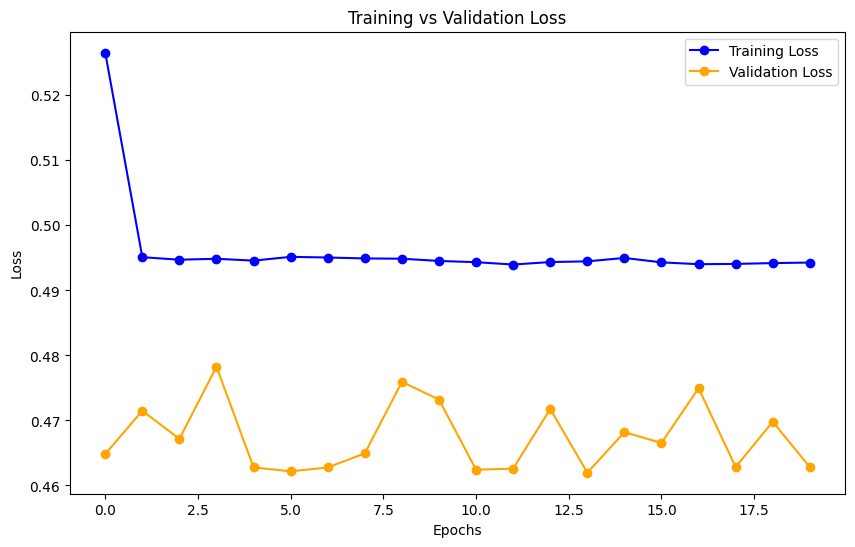

In [ ]:
# Extracting model 5 hyper-parameters
model_num = 5
hyperparams = regression_model_hyperparams[model_num - 1]

# Training the model
model = CNN(task=hyperparams["task"], act_func=hyperparams["act_func"], lr=hyperparams["lr"], dropout=hyperparams["dropout"], optimiser=hyperparams["optimiser"]).to(device)
print(f"Training started of Model {hyperparams['model_name']}, with parameters:\n{hyperparams}")
start_time = time.time()
train_loss_arr, val_loss_arr = model.train_model(train_images, train_labels, val_images, val_labels, n_epochs)
end_time = time.time()
print("\nTraining Complete, time taken:", end_time - start_time)
print(f"Test Accuracy: {model.accuracy(test_images, test_labels)}")
print(f"Test MSE: {model.get_loss(test_images, test_labels)}")

# Plotting loss graph
plot_loss_graph(train_loss_arr, val_loss_arr, f"/content/drive/MyDrive/smai_a4/figures/{hyperparams['task']}/model_{hyperparams['model_name']}_loss.png")

# Saving the model
torch.save(model.state_dict(), f"/content/drive/MyDrive/smai_a4/saved_models/{hyperparams['task']}/model_{hyperparams['model_name']}.pth")
print(f"Saved {hyperparams['task']} model {hyperparams['model_name']}")

## Visualising feature maps of the best model

In [ ]:
# After analysing all the outputs of the previous model I concluded that Classification model 2 works the best so visualising the intermediate feature maps of the model
best_model_number = 2
hyperparams = model_hyperparams[best_model_number - 1]

test_model = CNN(task=hyperparams["task"], act_func=hyperparams["act_func"], lr=hyperparams["lr"], dropout=hyperparams["dropout"], optimiser=hyperparams["optimiser"]).to(device)
test_model.load_state_dict(torch.load(f"/content/drive/MyDrive/smai_a4/saved_models/{hyperparams['task']}/model_{hyperparams['model_name']}.pth", map_location=torch.device('cpu')))
test_model.visualise_feature_maps(selected_images, selected_labels, save_as="/content/drive/MyDrive/smai_a4/figures/feature_map_visualisation/feature_map")

<ipython-input-25-264e61031d0c>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  test_model.load_state_dict(torch.load("/content/drive/MyDrive/smai_a4/saved_models/classific

> After analysing the feature maps, we can say that the first layer is sort of trying to learn the various edges and features that make up the hand written digits whereas the second layer is trying to learn the position and number of digits present - segmenting each digit.